In [662]:
# Importing necessary libraries and organise view settings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [663]:
# Reading and first look at the dataset
df = pd.read_csv("datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [664]:
df.shape

(768, 9)

In [665]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [666]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [667]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name,q1=0.05, q3=0.95)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [668]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [669]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [670]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [671]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [672]:
def label_encoder(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    return dataframe

In [673]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [674]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [675]:
# Mean of numerical variables relative to the target variable(Outcome)
for col in num_cols:
    print(df.groupby("Outcome").agg({col: "mean"}))

         Pregnancies
Outcome             
0              3.298
1              4.866
         Glucose
Outcome         
0        109.980
1        141.257
         BloodPressure
Outcome               
0               68.184
1               70.825
         SkinThickness
Outcome               
0               19.664
1               22.164
         Insulin
Outcome         
0         68.792
1        100.336
           BMI
Outcome       
0       30.304
1       35.143
         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550
           Age
Outcome       
0       31.190
1       37.067


In [676]:
# Outlier analysis
for col in num_cols:
    if check_outlier(df, col):
        grab_outliers(df, col)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
13             1      189             60             23      846 30.100                     0.398   59        1
228            4      197             70             39      744 36.700                     2.329   31        0


In [677]:
# Missing value analysis
df.isnull().any()
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


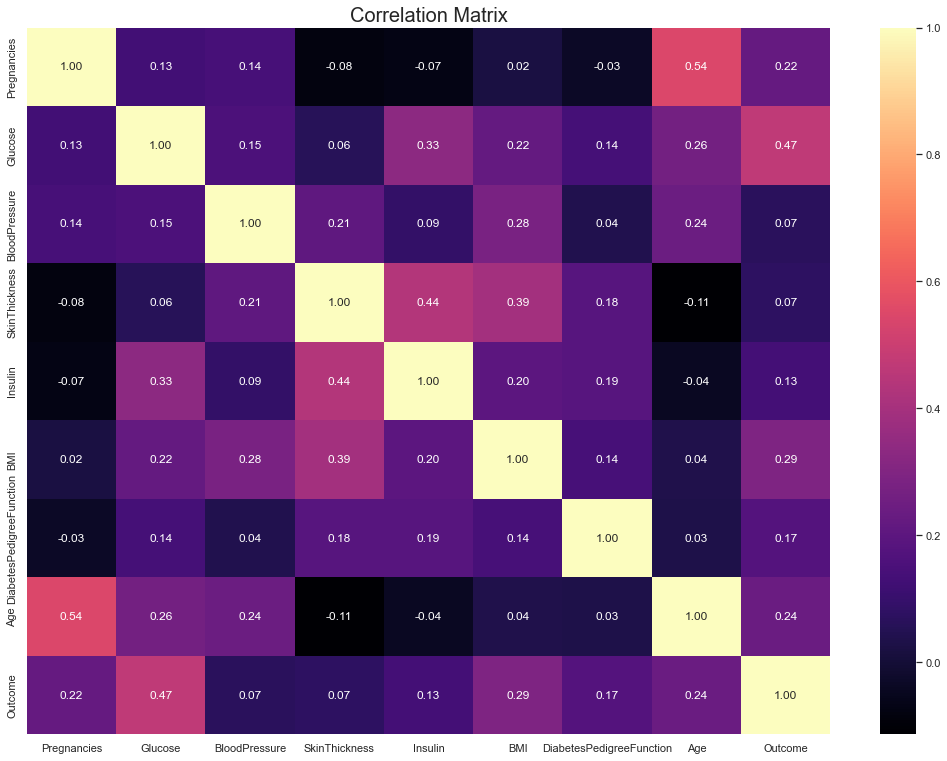

In [678]:
# Correlation analysis
df.corr()
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [679]:
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


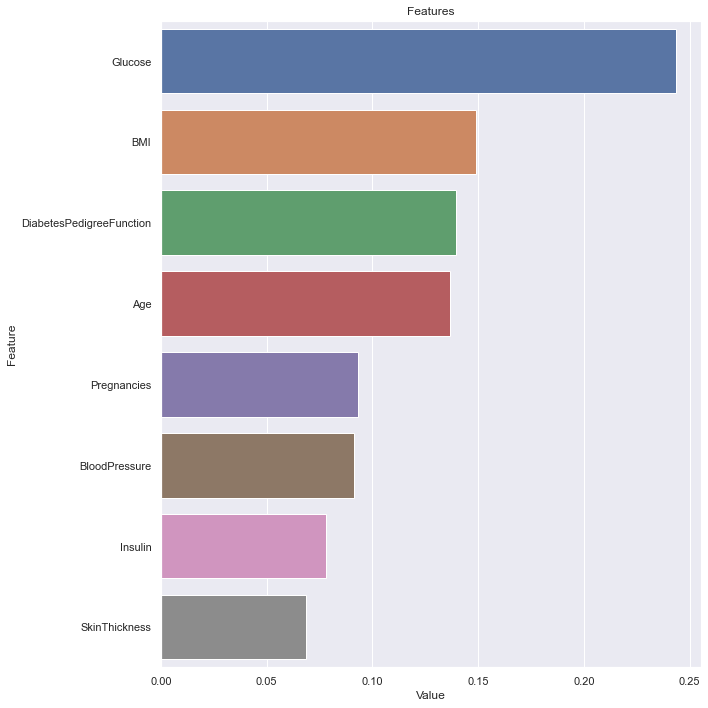

In [680]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
plot_importance(rf_model, X)

In [681]:
# Although there are no missing observations in the data set, Glucose, Insulin etc. Observation units containing a value of 0 in the variables may represent the missing value. For this reason, these values were assigned NaN.
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
for col in zero_columns:
    df[df[zero_columns]==0] =  float("NaN")

In [682]:
missing_vs_target(df, "Outcome",zero_columns )

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [683]:
df.isnull().any()

Pregnancies                 False
Glucose                      True
BloodPressure                True
SkinThickness                True
Insulin                      True
BMI                          True
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [684]:
missing_values_table(df)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [685]:
# Missing data were filled with median because it was less affected by outliers than meane
df = df.apply(lambda x:x.fillna(x.median()))

In [686]:
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [687]:
# Replace outliers with threshold values
for col in df.columns:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [688]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [689]:
# Creating a new age variable by dividing the age variable into categories
df["NEW_CAT_AGE"] = ["mature" if 21 <= value < 51 else "senior" for value in df["Age"]]

In [690]:
# Creating a new BMI variable by dividing the BMI variable into categories
df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],
                       labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [691]:
# Creating a new Glucose variable by dividing the Glucose variable into categories
df["NEW_CAT_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

In [692]:
# Creating a new variable by dividing the BMI and Age variables into categories
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI"] = "underweight_mature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI"] = "underweight_senior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI"] = "healthy_mature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI"] = "healthy_senior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI"] = "overweight_mature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI"] = "overweight_senior"
df.loc[(df["BMI"] > 30) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI"] = "obese_mature"
df.loc[(df["BMI"] > 30) & (df["Age"] >= 50), "NEW_AGE_BMI"] = "obese_senior"

In [693]:
# Creating a new variable by dividing the Glucose and Age variables into categories
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE"] = "low_mature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE"] = "low_senior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE"] = "normal_mature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE"] = "normal_senior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE"] = "hidden_mature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE"] = "hidden_senior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE"] = "high_mature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE"] = "high_senior"

In [694]:
# Creating a new Insulin variable by dividing the Insulin variable into categories
df["NEW_CAT_INSULIN"] = ["normal" if 16 <= value <= 166 else "abnormal" for value in df["Insulin"]]

In [695]:
df.columns = [col.upper() for col in df.columns]
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_CAT_AGE,NEW_BMI,NEW_CAT_GLUCOSE,NEW_AGE_BMI,NEW_AGE_GLUCOSE,NEW_CAT_INSULIN
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,mature,Obese,Prediabetes,obese_senior,high_senior,normal
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,overweight_mature,normal_mature,normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,healthy_mature,high_mature,normal
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,overweight_mature,normal_mature,normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obese_mature,high_mature,abnormal


In [696]:
df["NEW_GLUCOSE_INSULIN"] = df["GLUCOSE"]*df["INSULIN"]
df["NEW_GLUCOSE_PREGNANCIES"] = df["GLUCOSE"] * df["PREGNANCIES"]
df["NEW_GLUCOSE_BLOODPRESSURE"] = df["BLOODPRESSURE"]*df["GLUCOSE"]
df["NEW_GLUCOSE_BMI"] = df["BMI"]*df["GLUCOSE"]

In [697]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
for col in binary_cols:
    df = label_encoder(df, col)
df = one_hot_encoder(df, cat_cols, drop_first=True)

Observations: 768
Variables: 19
cat_cols: 7
num_cols: 12
cat_but_car: 0
num_but_cat: 3


In [698]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [699]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.8
Recall: 0.724
Precision: 0.68
F1: 0.7
Auc: 0.78


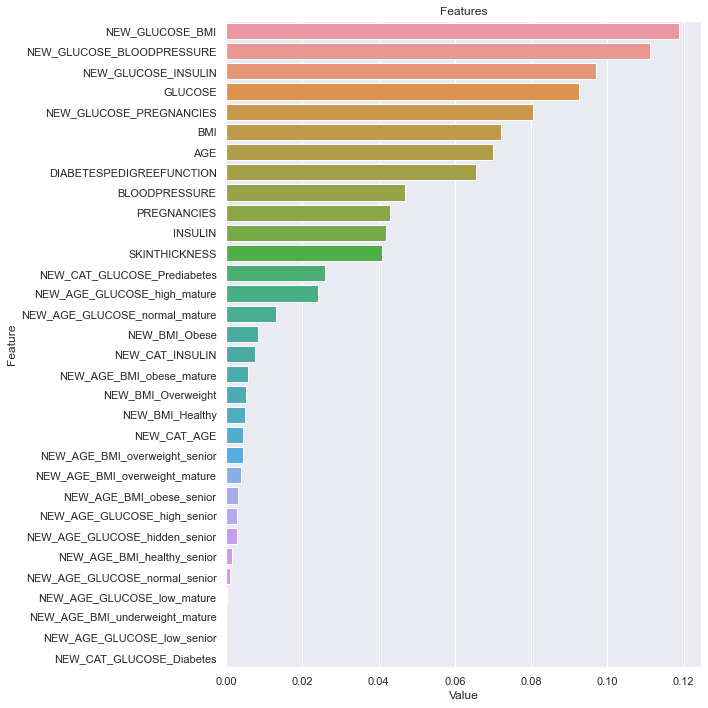

In [700]:
plot_importance(rf_model, X)